## Understanding DBMapper
DBMapper is an algorithm for learning a discrete approximation of the 1-dimensional topology of a manifold. It is a density-sensitive augmentation of the Mapper algorithm in topological data analysis (cite here).

This article will provide a high-level overview of how DBMapper works, and how it differs from Mapper. In theory, DBMapper is founded on Morse theory and persistent homology, but in practice it can be understood without these mathematical tools.

As DBMapper is mostly Mapper, we start with an explanation of Mapper itself.

### Mapper

Mapper helps us describe the topology of a manifold $X$ using a set of samples from the manifold, by approximating the *Reeb graph* of the manifold with respect to some Morse-type function $f:X\to \mathbb{R}$. This Reeb graph is a 1-dimensional representation of $X$, which captures its $0$- and $1$- dimensional topological features; that is, connected components and holes respectively.  

To do this, it constructs a finite graph $G$ as follows:
1. Split $f(X)\subset\mathbb{R}$ into overlapping interval bins $I_1,...,I_N$
2. For each bin $I_k$, cluster all the samples $x$ for which $f(x) \in I_k$.
3. Add a vertex $c^k_i$ to $G$ for each cluster $c_i$ in $I_k$.
4. Add an edge between $c^k_i$ and $c^{k+1}_j$ with weight equal to the number of points their corresponding clusters share in common. 

Let us demonstrate this now with the `TemporalMapper` object.

In [1]:
import temporalmapper as tm
import temporalmapper.utilities_ as tmutils
import temporalmapper.weighted_clustering as tmwc
import numpy as np
import matplotlib.pyplot as plt
import requests, io
from sklearn.cluster import DBSCAN
from mpl_toolkits.axes_grid1 import make_axes_locatable

For this demonstration, we will load a synthetic test file with points sampled from a $2$-dimensional manifold with fairly uniform density.

We will use the $x$-axis as the Morse-type function $f$, called `time` in the code snippets below.

In [2]:
demo_data_file = requests.get("https://github.com/TutteInstitute/temporal-mapper/raw/docs/docs/data/mapper_demo_data.npy")
data_time = np.load(io.BytesIO(demo_data_file.content)) 
data_unsort = data_time[:,1].T
time_unsort = data_time[:,0].T
sorted_indices = np.argsort(time_unsort)
data = data_unsort[sorted_indices]
time = time_unsort[sorted_indices]

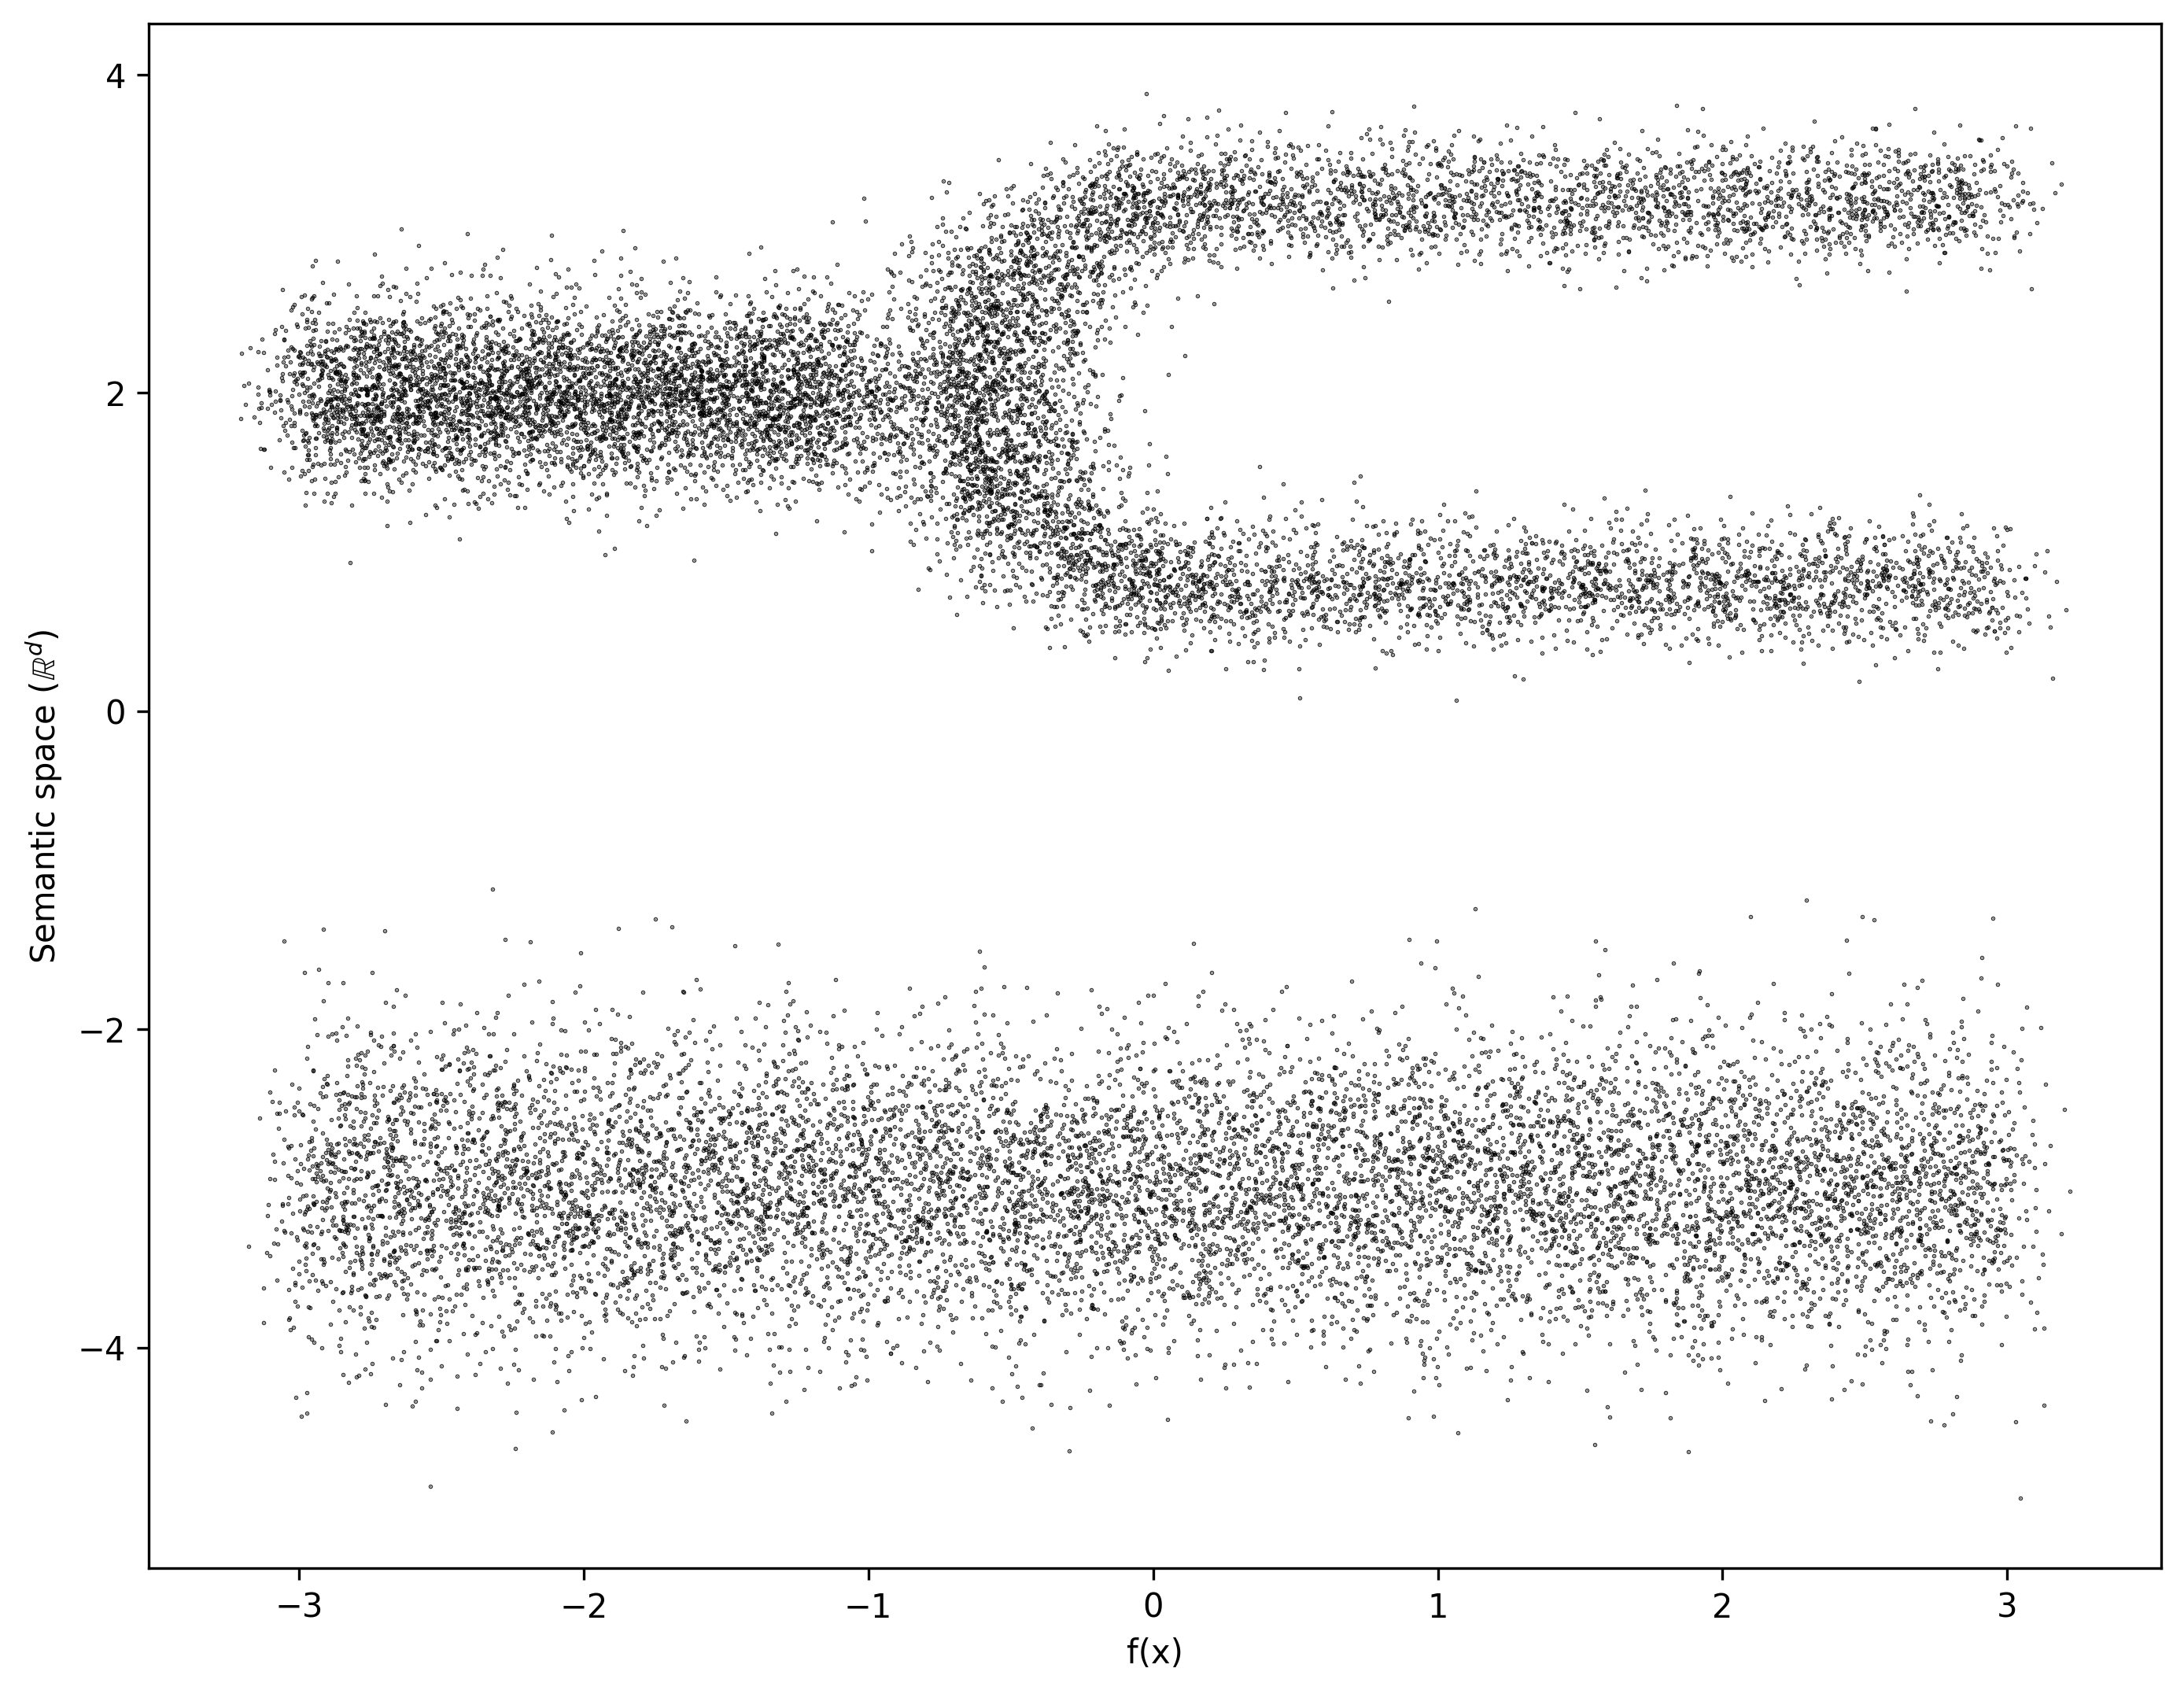

In [3]:
fig, ax = plt.subplots(1,1)
fig.set_figwidth(11)
fig.set_figheight(8.5)
ax.scatter(time,data,s=0.1,c='k',alpha=0.8)
ax.set_ylabel("Semantic space ($\mathbb{R}^d$)")
ax.set_xlabel("f(x)")
fig.dpi = 300
plt.show()

By setting `rate_sensitivity=0`, we skip the density computation step completely, reducing DBMapper to Mapper.

In [4]:
clusterer = DBSCAN(eps=0.1)
N_checkpoints = 10
TM = tm.TemporalMapper(
    time,
    data,
    clusterer,
    N_checkpoints = N_checkpoints,
    overlap = 0.5,
    rate_sensitivity=0,
)
TM.fit()

Step 1 of the Mapper procedure is to split the image of $f$ in $\mathbb{R}$ into overlapping bins. Our samples have $f(x) \in [-3,3]$, and we initialized the `TemporalMapper` with `N_checkpoints=10` and `overlap=0.5`, so it splits $[-3,3]$ into 10 intervals that overlap by half of the maximum allowable amount. 

We can visualize this open cover of $f(X)$ with a *sliceograph*, similar to a barcode diagram, where each bar in the graph shows the extent of one interval in the cover.

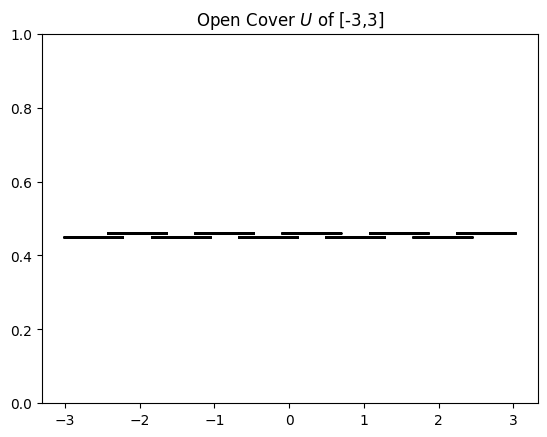

In [5]:
fig = plt.Figure(figsize = (10,3))
ax = plt.axes()
tmutils.sliceograph(TM, ax=ax)
plt.title("Open Cover $U$ of [-3,3]")
plt.show()

Steps 2 and 3 of the Mapper procedure are to cluster the points whose $f$ values lie within each interval, and then add one vertex to the output graph $G$ for each cluster. 

In the next cell, we will look at the clustering results (using DBSCAN) for the 5th and 6th intervals:

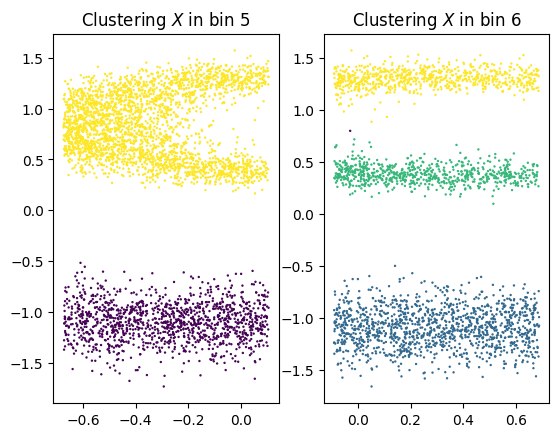

In [6]:
index_1 = 4
index_2 = 5
slice_1 = (TM.weights[index_1] >= 0.1).nonzero()
slice_2 = (TM.weights[index_2] >= 0.1).nonzero()
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.set_title("Clustering $X$ in bin 5")
ax1.scatter(TM.time[slice_1], TM.data[slice_1],
            s=0.5, c=TM.clusters[index_1,slice_1])
ax2.set_title("Clustering $X$ in bin 6")
ax2.scatter(TM.time[slice_2], TM.data[slice_2],
            s=0.5, c=TM.clusters[index_2,slice_2])
plt.show()

The points in bin 5 are partitioned into two clusters, so we will add two vertices $c^5_1$ and $c^5_2$ to the graph. The points in bin 6 are partitioned into three clusters, so we will add three vertices to the graph.

Finally, step 4 of Mapper tells us to draw edges between these vertices with weights given by the number of points in the intersection of the vertices. 

From the figure above, we can see that the left-hand size yellow cluster intersects the right-hand-size yellow and green clusters. The purple cluster intersects the blue cluster.

Once we add edges for each intersection $I_k \cap I_{k+1}$ in the open cover, we can visualize the resulting graph $G$ using one of the visualization options included in `temporalmapper.utilities`. In this visualization, the vertices are positioned on the centroids of the data contained in the corresponding cluster.

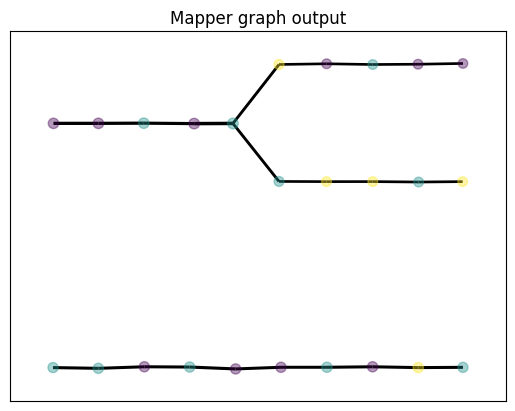

In [7]:
tmutils.time_semantic_plot(TM, TM.data)
plt.title("Mapper graph output")
plt.show()

Comparing this graph to the data itself, one can see how Mapper captures a 1-dimensional representation of the manifold.

### DBMapper
Now that we understand Mapper, we can explain DBMapper.

DBMapper is built to address the fragility of Mapper's results under change-of-parameters for data sampled from a manifold with non-uniform density. Mapper requires a choice of the number of intervals $N$ and the percentage overlap $g$ of the intervals. These parameters determine the *resolution* of topological features that one can detect. As $N$ grows and $g$ shrinks, one can detect smaller topological features.

However, when one has finite samples from the manifold $X$, this imposes a limit on how large one can choose $N$ and how small one can choose $g$. Mapper draws edges based on samples in the overlap of clusters. As the resolution is improved, the probability of having samples in the intersection decreases. Thus, Mapper will draw fewer and fewer edges, disconnecting the graph more and more.

This means there is some optimal parameters for any given dataset, which can detect the most topological features, but without spurriously disconnecting the manifold. This optimal choice is not knowable unless one already knows the topology of the underlying manifold. It also varies for different regions in the manifold with different densities.

To demonstrate this, let's run Mapper on another synthetic dataset, this time with varying local density. The samples are taken from a 2d manifold with two components, with high sampling density from one and low from the other. The high density component has a genus-1 topological feature.

We will use the $x$-axis as a Morse function, again labeled `time` in the code snippets.

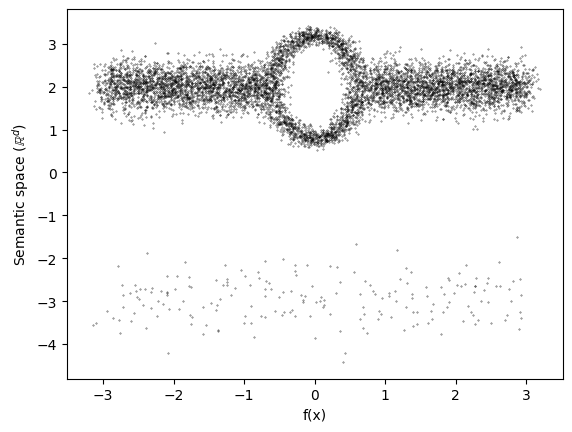

In [8]:
demo_data_file = requests.get("https://github.com/TutteInstitute/temporal-mapper/raw/docs/docs/data/genus1_demo.npy")
data_time = np.load(io.BytesIO(demo_data_file.content)) 
data_unsort = data_time[:,1].T
time_unsort = data_time[:,0].T
sorted_indices = np.argsort(time_unsort)
data = data_unsort[sorted_indices]
time = time_unsort[sorted_indices]
fig, ax = plt.subplots(1,1)
ax.scatter(time,data,s=0.1,c='k',alpha=0.8)
ax.set_ylabel("Semantic space ($\mathbb{R}^d$)")
ax.set_xlabel("f(x)")
plt.show()

Now let's run Mapper on this dataset with a small range of parameters. The resolution improves as we move from the top left to the bottom right in the grid of figures. 

For the low resolution parameters, Mapper finds both components of the manifold and correctly connects them across the range of $x$ values, but it doesn't find the loop. For the high resolution parameters, Mapper finds the loop, but it disconnects the low resolution component. This is showing us how the optimal resolution of the high density region of the manifold is much better than the optimal resolution of the low density region.

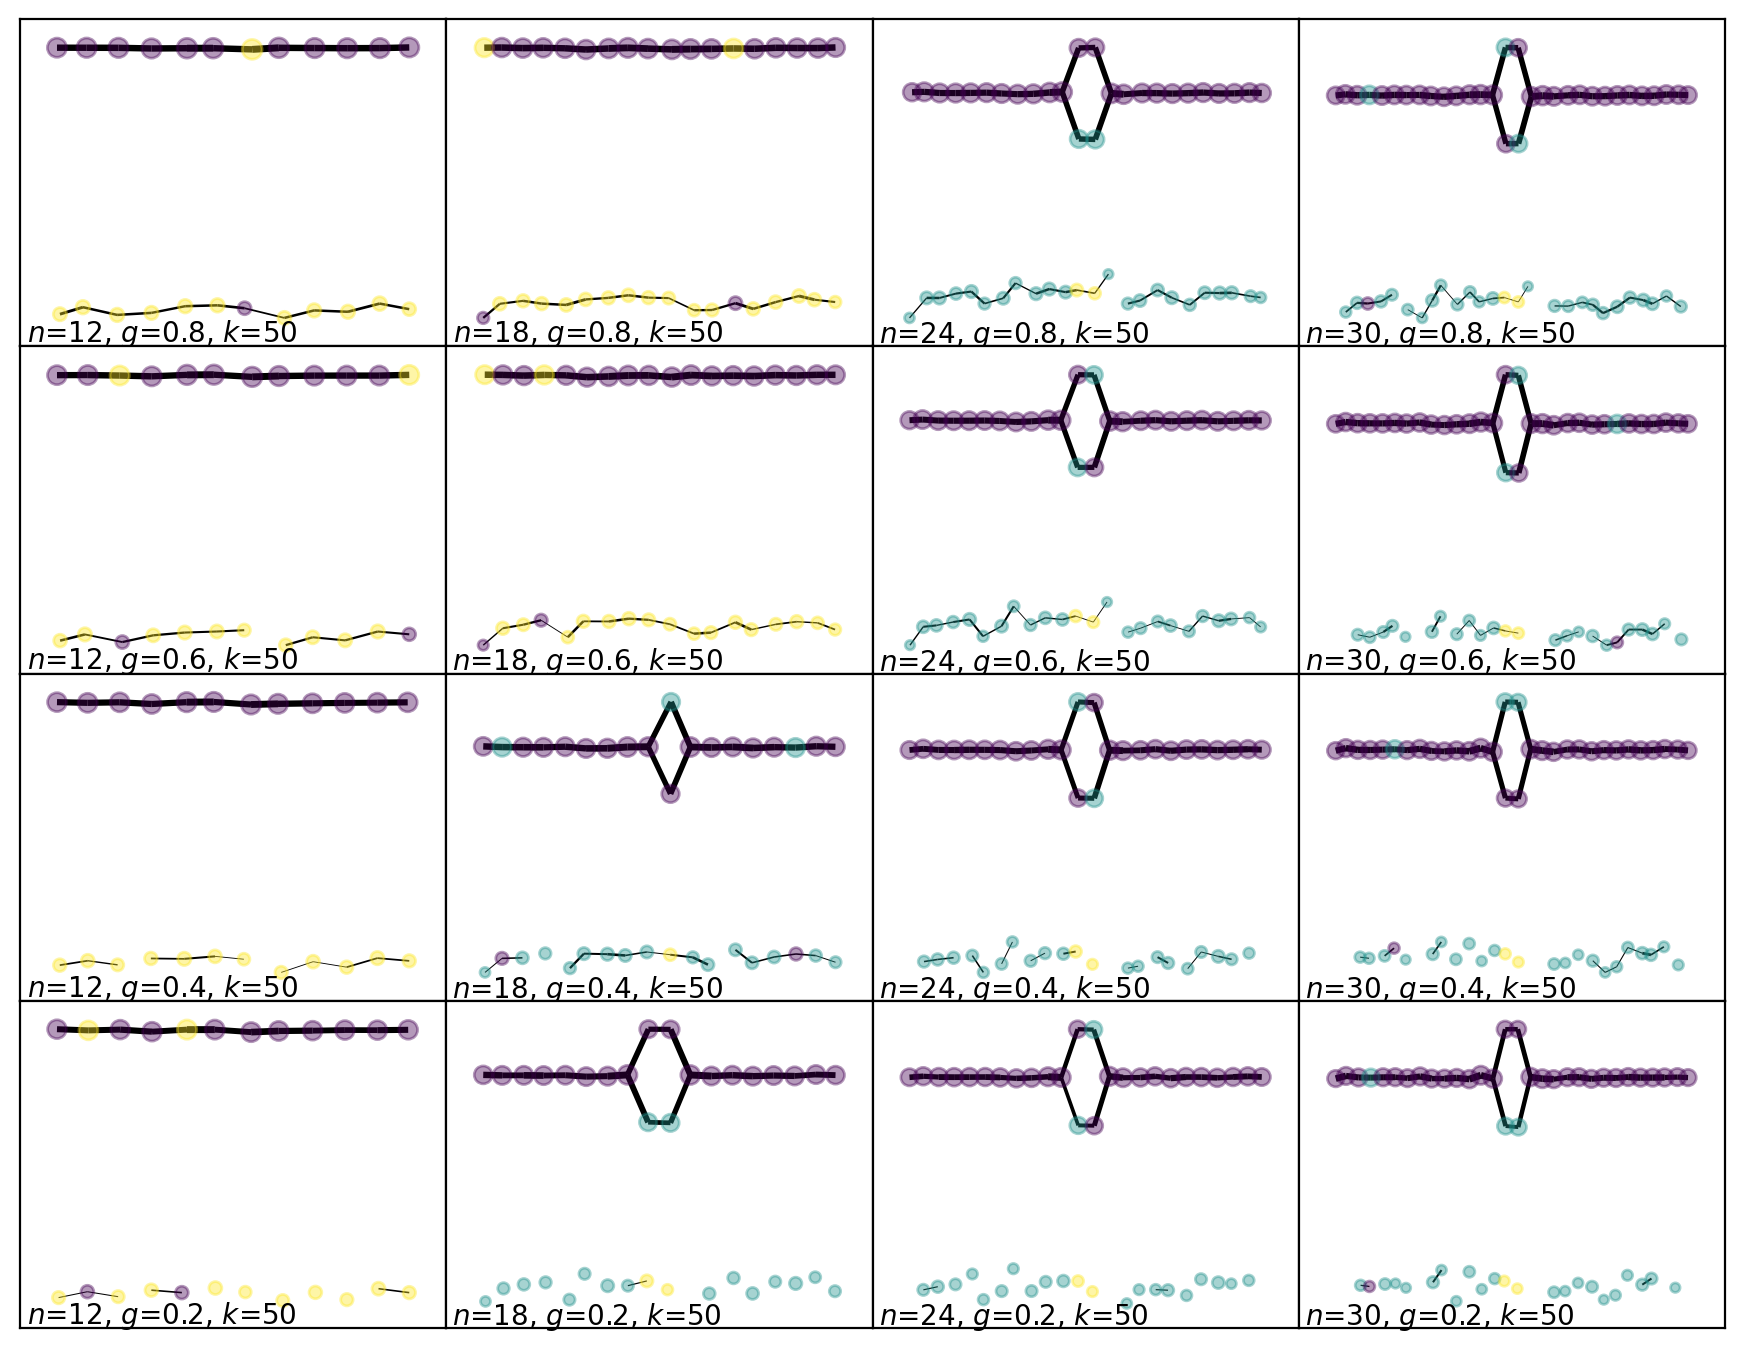

In [9]:

checkpoint_numbers = [12,18,24,30]
overlap_parameters = [0.8,0.6,0.4,0.2]

fig, axes = plt.subplots(4,4)
fig.set_figwidth(11)
fig.set_figheight(8.5)
fig.dpi = 200
axes = axes.reshape(4*4)
clusterer = DBSCAN()
j = 0
for k in range(16):
    TM = tm.TemporalMapper(
        time,
        data,
        clusterer,
        N_checkpoints = checkpoint_numbers[k%4],
        neighbours = 50,
        overlap = overlap_parameters[j],
        rate_sensitivity=0,
        kernel=tmwc.square
    )
    TM.fit()
    tmutils.time_semantic_plot(TM, data, ax=axes[k])
    xmin,xmax=axes[k].get_xlim()
    ymin,ymax=axes[k].get_ylim()
    axes[k].text(xmin+0.1,ymin+0.1,fr'$n$={TM.N_checkpoints}, $g$={TM.g}, $k$={50}')
    if k%4==3:
        j+=1
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


Now let's see how DBMapper solves this problem.

Taking the 4-step description of Mapper above, DBMapper is exactly the same in steps 1, 3 and 4. Step 2 is changed to take the local density of the samples into account, as we will now describe.

In Step 2, we took each interval $I_k$ in the chosen cover of $f(X)$, found the set of points for which $f(X) \in I_k$, and clustered that set. If we let $\mathbb{X}_n$ denote our set of samples from $X$, then the set we are clustering is
$$ U_k := f^{-1}(I_k) \cap \mathbb{X}_n.$$
What density-based Mapper does is replace this pullback set $U_k$, with a *kerneled-pullback* set $V_k$, which is sensitive to the local density of $\mathbb{X}_n$.

One way to define $U_k$ is by thinking of putting a square kernel $K$ on the set $f(X)$, with bounds defined by $I_k$. If we let $m_k$ denote the midpoint of the interval $I_k$, and $w$ the width of $I_k$, then we can define
$$ K_k(x) = \begin{cases}
    1 & |f(x)-f(m_k)| < w/2, \\
    0 & else
   \end{cases} $$
Then $U_k = K_k^{-1}(1)$.

Now suppose that we let $\lambda(x)$ denote the local density of $\mathbb{X}_n$ near $x$. We can imagine a square kernel whose width depends on the local density; $w(\lambda)$, and defining a density sensitive kernel:
$$ K_k(x) = \begin{cases}
    1 & |f(x)-f(m_k)| < w(\lambda)/2, \\
    0 & else
   \end{cases} $$
   
By choosing a good function $w(\lambda)$, we can refine the cover we use in Mapper in regions of high density, while keeping the cover coarse in regions of low density.

Let's initialize a new `TemporalMapper` object, this time with `rate_sensitivity=1` so that it will use these density sensitive kernels.

In [10]:
TM = tm.TemporalMapper(
    time,
    data,
    clusterer,
    N_checkpoints = 30,
    neighbours = 50,
    rate_sensitivity=1,
    kernel=tmwc.square
)
TM.fit()

We can compare the sets $U_k$ and $V_k$ used in Mapper and DBMapper respectively:

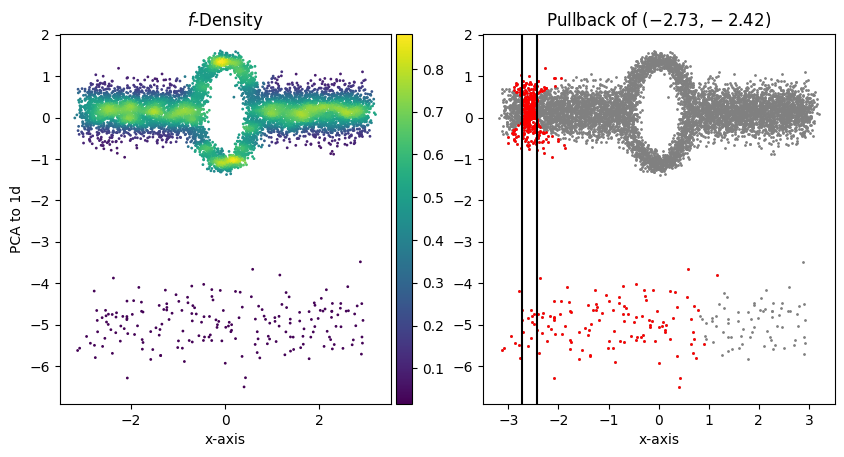

In [11]:

idx=2
slice_ = (TM.weights[idx] >= 0.1).nonzero()
cp_with_ends = [np.amin(time)]+list(TM.checkpoints)+[np.amax(time)]
bin_width = (cp_with_ends[idx+1]-cp_with_ends[idx])

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(10)

ax1.set_title(f"$f$-Density")
sca=ax1.scatter(time,data,s=1,c=TM.density)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sca, cax=cax, orientation='vertical')
ax1.set_xlabel("x-axis")
ax1.set_ylabel("PCA to 1d")


tstr = f'Pullback of $({TM.checkpoints[idx]-(bin_width/2)*(1+TM.g):.2f},{TM.checkpoints[idx]+bin_width/2*(1+TM.g):.2f})$'
ax2.set_title(tstr)
ax2.scatter(time,data,s=1,c='grey')
ax2.scatter(time[slice_],data[slice_],s=1,c='red')
ax2.set_xlabel("x-axis")
ax2.axvline(TM.checkpoints[idx]+(bin_width/2)*(1+TM.g),c='k')
ax2.axvline(TM.checkpoints[idx]-(bin_width/2)*(1+TM.g),c='k')
plt.show()

The left-side plot shows the approximated local $f$-density of the samples and the right-side plot shows the set $V_{2}$. Points coloured red are in $V_{2}$, and the black lines show the extent of the interval $I_2$. Points between the black lines would be in $U_{2}$ using regular Mapper. Comparing the two plots, we see that as the density decreases, the width of $V_{2}$ increases. This has the effect of lowering the resolution of DBMapper in regions of the manifold with low density.

Finally, we can run DBMapper over the same range of parameters that we ran Mapper above.

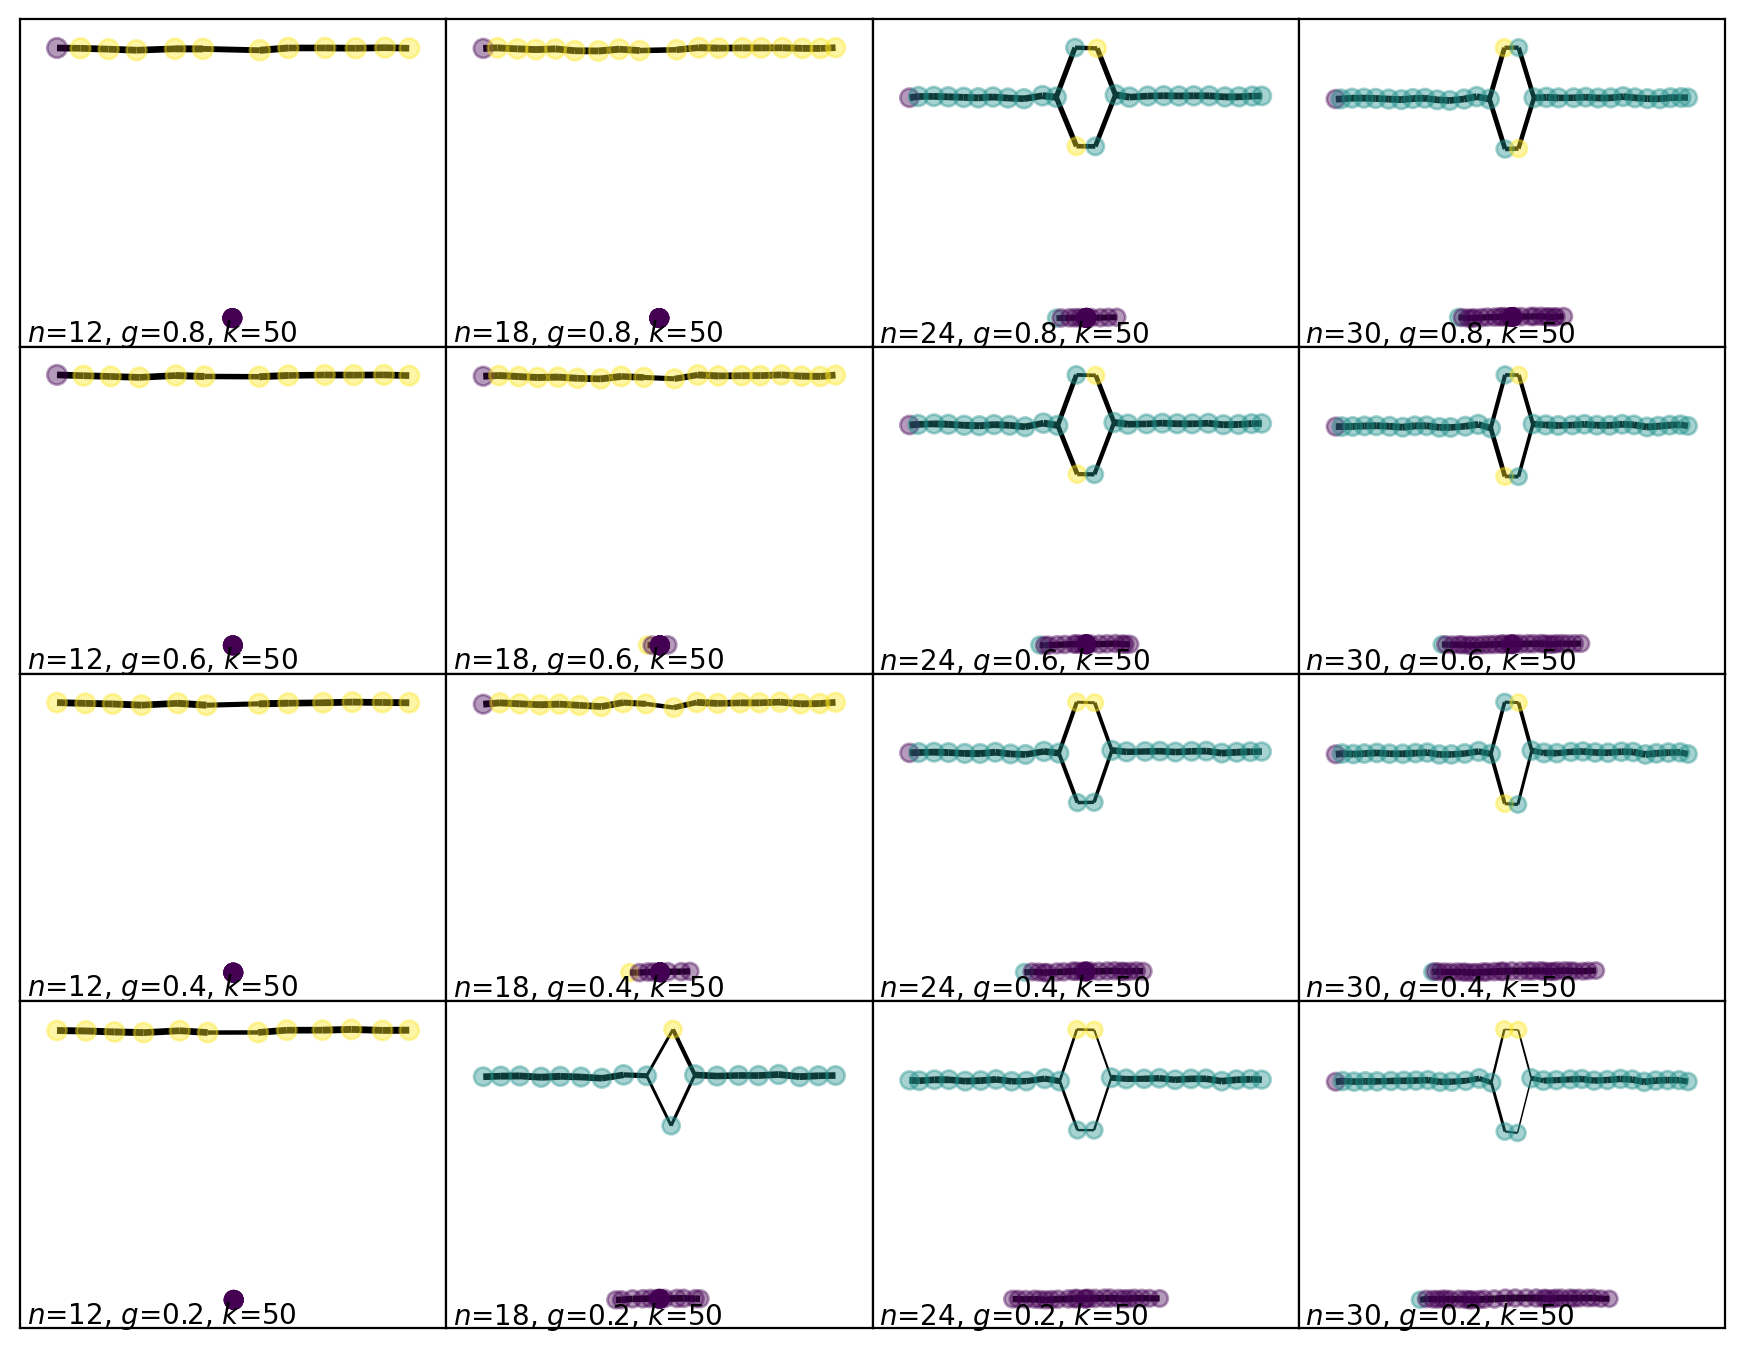

In [12]:

checkpoint_numbers = [12,18,24,30]
overlap_parameters = [0.8,0.6,0.4,0.2]

fig, axes = plt.subplots(4,4)
fig.set_figwidth(11)
fig.set_figheight(8.5)
fig.dpi = 200
axes = axes.reshape(4*4)
clusterer = DBSCAN()
j = 0
for k in range(16):
    TM = tm.TemporalMapper(
        time,
        data,
        clusterer,
        N_checkpoints = checkpoint_numbers[k%4],
        neighbours = 50,
        overlap = overlap_parameters[j],
        rate_sensitivity=1, ### Changing this from 0 -> 1 activates DBMapper
        kernel=tmwc.square,
    )
    TM.fit()
    tmutils.time_semantic_plot(TM, data, ax=axes[k])
    xmin,xmax=axes[k].get_xlim()
    ymin,ymax=axes[k].get_ylim()
    axes[k].text(xmin+0.1,ymin+0.1,fr'$n$={TM.N_checkpoints}, $g$={TM.g}, $k$={50}')
    if k%4==3:
        j+=1
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


With DBMapper there is a wider range of parameters which finds both components and the loop. One interesting effect of the choice to use centroids to position the vertices is that DBMapper pulls the vertices of sparser component closer together, uniformizing the density of points in the output graph. We suspect that DBMapper is equivalent to first uniformizing the local density using theoretical methods like those underlying UMAP, and then performing regular Mapper, but we don't yet have a strong understanding of this.